In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard

In [2]:
tf.__version__

'2.0.0'

In [3]:
dataset_path = '../datasets/emilwallner-datasets-colornet-2/images/Train/'
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [4]:
def image_gen(path):
    for file in os.listdir(path):
        img_path = os.path.join(dataset_path, file)
        img = np.array(load_img(img_path), dtype=float)
        yield img

# Training

In [5]:
model = Sequential([
    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(128, 3, padding='same', activation='relu'),
    UpSampling2D((2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    UpSampling2D((2, 2)),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D((2, 2)),
    Conv2D(2, 3, padding='same', activation='tanh'), 
])
model.compile(optimizer='adam', loss='mse')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [7]:
batch_size = 1
dataset_size = 10

X = []
gen = image_gen(dataset_path)
for _ in range(dataset_size):
    img = next(gen)
    X.append(img)
X = np.array(X, dtype=float)
print(X.shape)

split = int(0.9*len(X))
X_train = X[:split]
X_train = 1.0/255*X_train

(10, 256, 256, 3)


In [8]:
datagen = ImageDataGenerator()
def image_a_b_gen(batch_size):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = color.rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0] / 100
        y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), y_batch)

In [9]:
TensorBoard(log_dir='/output')
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=5, epochs=500)

Epoch 1/500
5/5 [==============================] - 2s 354ms/step - loss: 0.0076
Epoch 2/500
5/5 [==============================] - 2s 308ms/step - loss: 0.0043
Epoch 3/500
5/5 [==============================] - 1s 290ms/step - loss: 0.0061
Epoch 4/500
5/5 [==============================] - 1s 279ms/step - loss: 0.0050
Epoch 5/500
5/5 [==============================] - 2s 321ms/step - loss: 0.0035
Epoch 6/500
5/5 [==============================] - 2s 313ms/step - loss: 0.0089
Epoch 7/500
5/5 [==============================] - 1s 296ms/step - loss: 0.0041
Epoch 8/500
5/5 [==============================] - 2s 308ms/step - loss: 0.0065
Epoch 9/500
5/5 [==============================] - 1s 289ms/step - loss: 0.0040
Epoch 10/500
5/5 [==============================] - 2s 306ms/step - loss: 0.0030
Epoch 11/500
5/5 [==============================] - 2s 397ms/step - loss: 0.0067
Epoch 12/500
5/5 [==============================] - 2s 300ms/step - loss: 0.0036
Epoch 13/500
5/5 [===================

In [10]:
img = color.rgb2lab(1.0/255*X[split:])
X_test = img[:,:,:,0]
X_test = X_test.reshape(X_test.shape+(1,)) / 100
y_test = img[:,:,:,1:]
y_test = y_test / 128
print(X_test.shape, y_test.shape)
print(model.evaluate(X_test, y_test, batch_size=batch_size))

(1, 256, 256, 1) (1, 256, 256, 2)
1/1 [==============================] - 0s 191ms/sample - loss: 0.0036
0.003560979850590229


In [11]:
print(X_test.min(), X_test.max())
print(y_test.min(), y_test.max())

0.04113329168737636 0.9907093945309149
-0.14348328209773648 0.25123713835101147


In [12]:
def concat_L_ab(L, ab):
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    img[:,:,0] = L[:,:,0] * 100
    img[:,:,1:] = ab * 128
    return color.lab2rgb(img)

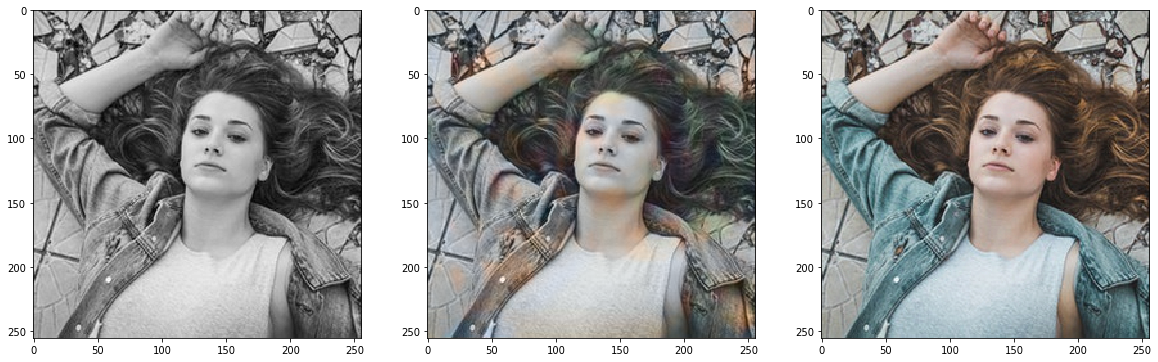

In [13]:
index = 0
img = X_test[index,:,:,:1]
label = y_test[index]

output = model.predict(np.array([img], dtype=float))

plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(img[:,:,0], cmap=plt.cm.gray)

plt.subplot(1,3,2)
plt.imshow(concat_L_ab(img, output), cmap=plt.cm.binary)

plt.subplot(1,3,3)
plt.imshow(concat_L_ab(img, label), cmap=plt.cm.binary)

plt.show()